# Imports

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import time
from ucimlrepo import fetch_ucirepo
from sklearn.compose import make_column_selector as selector
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import lime.lime_tabular
import shap
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from DatasetAnalysis import DatasetAnalysis
from PerformanceAnalysis import PerformanceAnalysis
from Visualization import Visualization
import pickle
import dill

# Setup

In [97]:
config_file = open("input_settings_darwin.json")
config_vars = json.load(config_file)
config_file.close()

models_dir = config_vars["models_dir"]

In [98]:
config_file = open("visual_config.json")
visual_vars = json.load(config_file)
config_file.close()

shap_colors_neg = visual_vars["shap_colors"]["negative"]
shap_colors_pos = visual_vars["shap_colors"]["positive"]
shap_colors = np.array([tuple(shap_colors_neg), tuple(shap_colors_pos)])

title_size = visual_vars["title_font_size"]
label_size = visual_vars["labels_font_size"]

green_color = tuple([x/255 for x in visual_vars["green_colors"]["c2"]])

# Get Dataset

In [99]:
dataset = pd.read_csv("datasets/DARWIN.csv", header=0)
X_pd = dataset.iloc[:, :-1]
y = dataset.iloc[:, -1]

The only categorical column is 'ID' which has no relevance for classification because is just an identifier of each experiment, so it will be dropped

In [100]:
X_pd = X_pd.drop(columns=["ID"])
features_names = X_pd.columns

In [101]:
X = X_pd.to_numpy()

In [102]:
#Convert from pandas to numpy and turn into a 1D array
y = y.to_numpy().ravel()
y = [0 if x == 'H' else 1 for x in y]

# Classification

In [103]:
perf_analysis = PerformanceAnalysis()

## <i>Logistic Regression</i> (LR)

In [104]:
lr_clf = LogisticRegression(solver="lbfgs", max_iter=500, C=0.01, random_state=42).fit(X, y)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Metrics,Values
accuracy,1.0
false-positive rate,0.0
false-negative rate,0.0
precision,1.0
recall,1.0
f-score,1.0


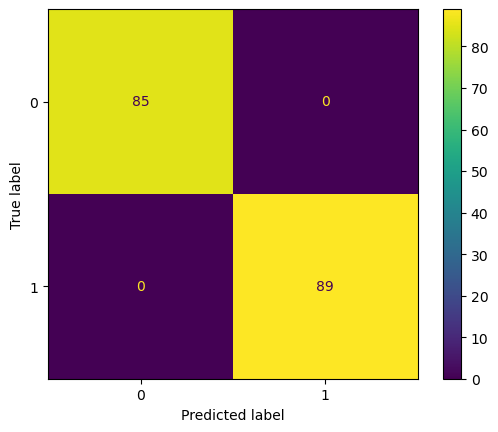

In [105]:
lr_ye = lr_clf.predict(X)

lr_cm = confusion_matrix(y, lr_ye)
lr_metrics = perf_analysis.compute_metrics(lr_cm)
display(lr_metrics)

ConfusionMatrixDisplay.from_predictions(y, lr_ye)

lr_y2d = lr_clf.predict_proba(X)[:, 1]

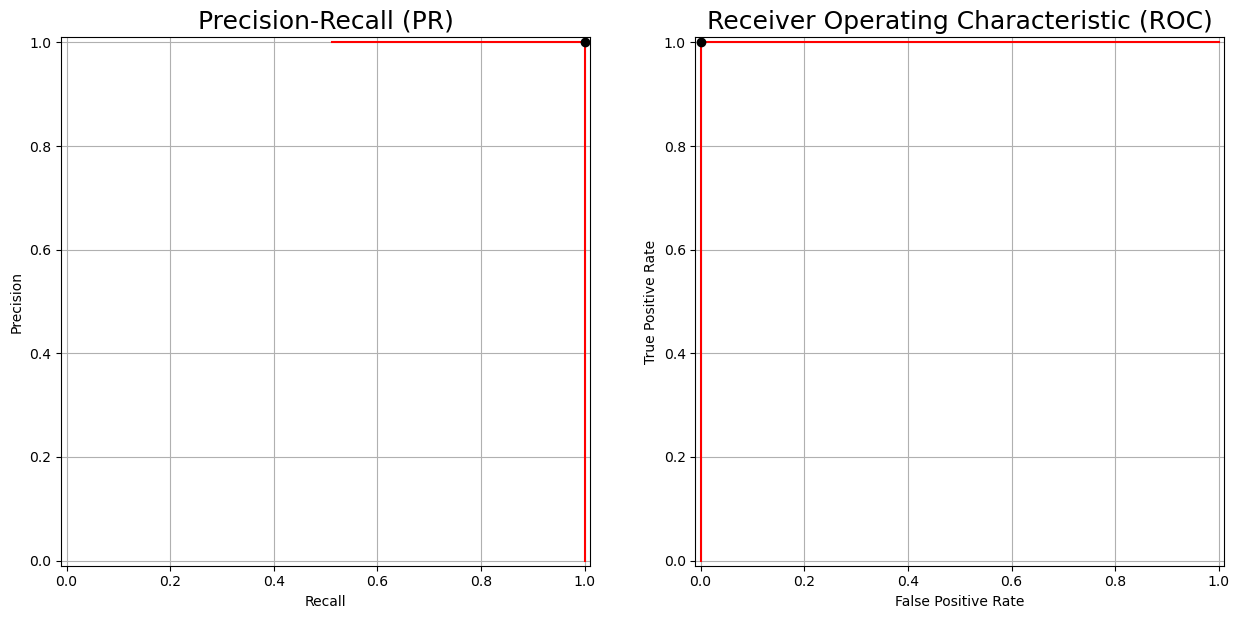

In [106]:
plt.figure(figsize=(15, 10))

plt.subplot(1,2,1)
perf_analysis.plot_PR(y, lr_cm, lr_y2d)

plt.subplot(1,2,2)
perf_analysis.plot_ROC(y, lr_cm, lr_y2d)

plt.show()

In [107]:
filename = "DARWIN_LR.pkl"
with open(f"{models_dir}/{filename}", 'wb') as file:
    pickle.dump(lr_clf, file)

In [108]:
features_names

Index(['air_time1', 'disp_index1', 'gmrt_in_air1', 'gmrt_on_paper1',
       'max_x_extension1', 'max_y_extension1', 'mean_acc_in_air1',
       'mean_acc_on_paper1', 'mean_gmrt1', 'mean_jerk_in_air1',
       ...
       'mean_gmrt25', 'mean_jerk_in_air25', 'mean_jerk_on_paper25',
       'mean_speed_in_air25', 'mean_speed_on_paper25', 'num_of_pendown25',
       'paper_time25', 'pressure_mean25', 'pressure_var25', 'total_time25'],
      dtype='object', length=450)

##### <i>Local Model-Agnostic Explanations</i> (LIME)

In [109]:
lime_explainer = lime.lime_tabular.LimeTabularExplainer(X, feature_names=features_names, random_state=42)
lr_LIME_explanation = lime_explainer.explain_instance(X[0,:], lr_clf.predict_proba)

In [110]:
filename = "DARWIN_LIME.dill"
with open(f"{models_dir}/{filename}", 'wb') as file:
    dill.dump(lime_explainer, file)

##### <i>SHapley Additive exPlanations</i> (SHAP)

In [111]:
lr_SHAP_exp = shap.KernelExplainer(lr_clf.predict_proba, shap.sample(X_pd, 50, random_state=42), random_state=42)

In [112]:
filename = "DARWIN_LR_SHAP.pkl"
with open(f"{models_dir}/{filename}", 'wb') as file:
    pickle.dump(lr_SHAP_exp, file)

## <i>Random Forest</i> (RF)

In [113]:
rf_clf = RandomForestClassifier(n_estimators=100, bootstrap=False, max_features="log2", random_state=42).fit(X, y)

Metrics,Values
accuracy,1.0
false-positive rate,0.0
false-negative rate,0.0
precision,1.0
recall,1.0
f-score,1.0


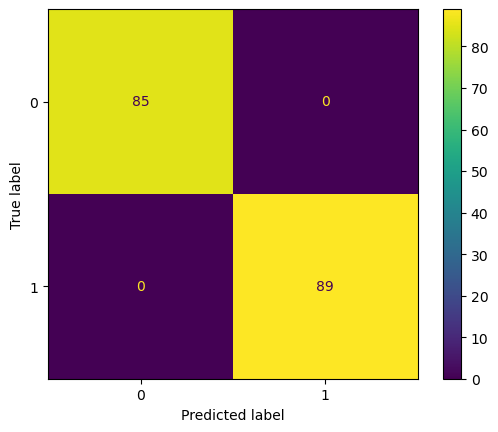

In [114]:
rf_ye = rf_clf.predict(X)

rf_cm = confusion_matrix(y, rf_ye)
rf_metrics = perf_analysis.compute_metrics(rf_cm)
display(rf_metrics)

ConfusionMatrixDisplay.from_predictions(y, rf_ye)

rf_y2d = rf_clf.predict_proba(X)[:, 1]

In [115]:
filename = "DARWIN_RF.pkl"
with open(f"{models_dir}/{filename}", 'wb') as file:
    pickle.dump(rf_clf, file)

##### <i>SHapley Additive exPlanations</i> (SHAP)

In [116]:
rf_SHAP_exp = shap.TreeExplainer(rf_clf, feature_names=features_names, random_state=42)

In [117]:
filename = "DARWIN_RF_SHAP.pkl"
with open(f"{models_dir}/{filename}", 'wb') as file:
    pickle.dump(rf_SHAP_exp, file)

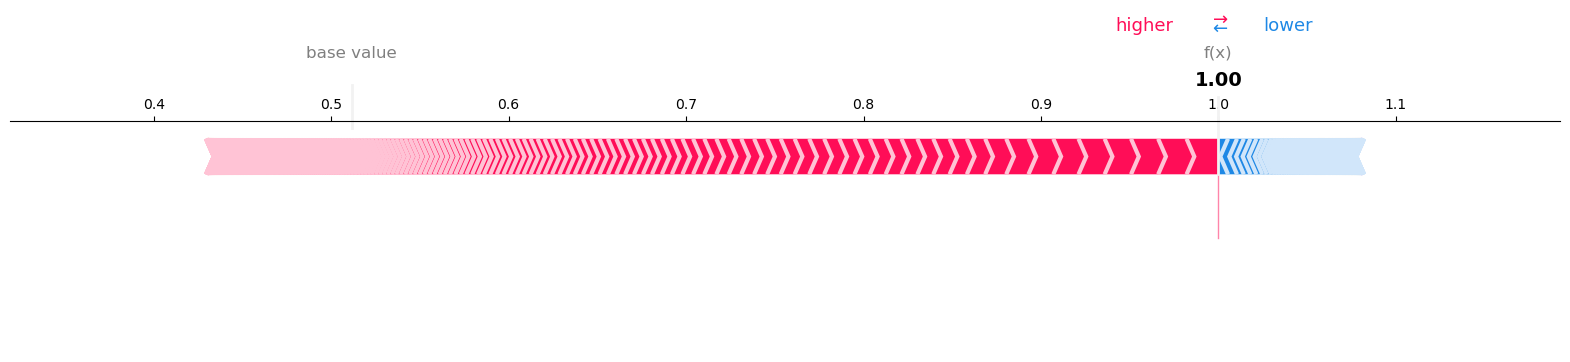

In [118]:
with open(f"{models_dir}/{filename}", 'rb') as file:
    loaded_model = pickle.load(file)

rf_shap_loc_values = np.array(loaded_model.shap_values(X_pd.iloc[3]))
shap.force_plot(loaded_model.expected_value[1], rf_shap_loc_values[1, :], X_pd.iloc[3], matplotlib=True)

## <i> Support Vector Machines</i> (SVM)

In [119]:
svm_clf = SVC(kernel="rbf", C=500, decision_function_shape="ovr", gamma="scale", probability=True, random_state=42).fit(X, y)

Metrics,Values
accuracy,0.959770
false-positive rate,0.023529
false-negative rate,0.056180
precision,0.976744
recall,0.943820
f-score,0.960000


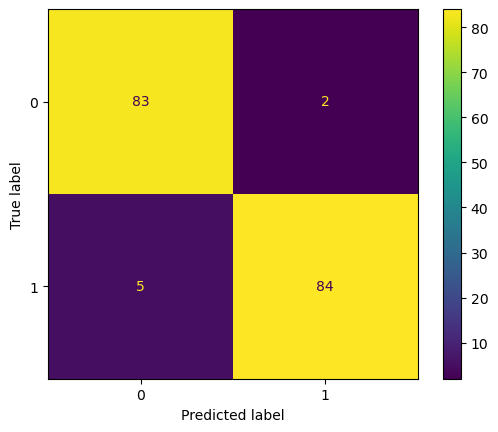

In [120]:
svm_ye = svm_clf.predict(X)

svm_cm = confusion_matrix(y, svm_ye)
svm_metrics = perf_analysis.compute_metrics(svm_cm)
display(svm_metrics)

ConfusionMatrixDisplay.from_predictions(y, svm_ye)

svm_y2d = svm_clf.predict_proba(X)[:, 1]

In [121]:
filename = "DARWIN_SVM.pkl"
with open(f"{models_dir}/{filename}", 'wb') as file:
    pickle.dump(svm_clf, file)

##### <i>SHapley Additive exPlanations</i> (SHAP)

In [122]:
svm_SHAP_exp = shap.KernelExplainer(svm_clf.predict_proba, shap.sample(X_pd, 50, random_state=42), random_state=42)

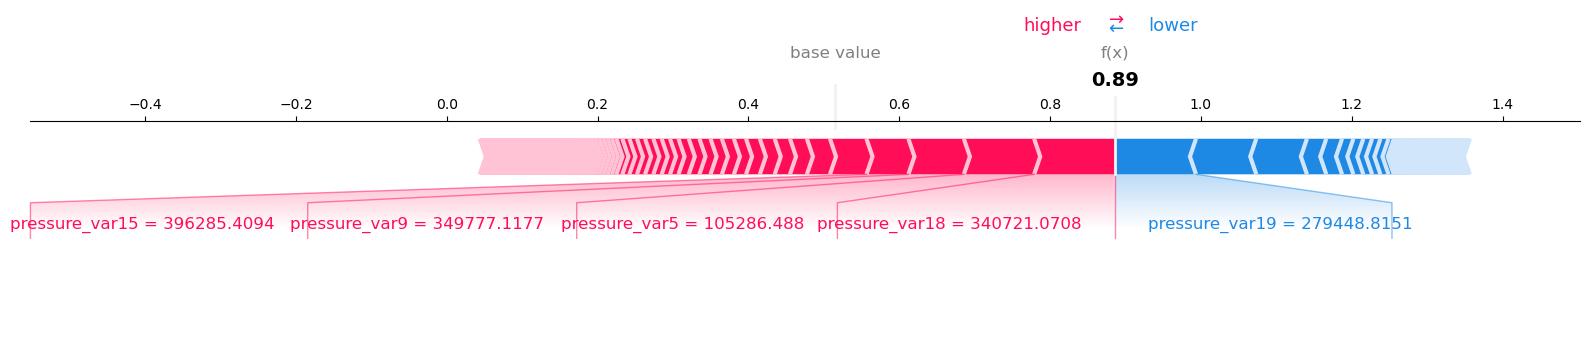

In [123]:
svm_shap_loc_values = np.array(svm_SHAP_exp.shap_values(X_pd.iloc[3]))
shap.force_plot(svm_SHAP_exp.expected_value[1], svm_shap_loc_values[1, :], X_pd.iloc[3, :], matplotlib=True)

In [124]:
filename = "DARWIN_SVM_SHAP.pkl"
with open(f"{models_dir}/{filename}", 'wb') as file:
    pickle.dump(svm_SHAP_exp, file)

## <i>Explainable Boosting Machine</i> (EBM)

In [125]:
ebm_clf = ExplainableBoostingClassifier(max_bins=1024, smoothing_rounds=500, cyclic_progress=0, interactions=0, random_state=42).fit(X_pd, y)

Metrics,Values
accuracy,1.0
false-positive rate,0.0
false-negative rate,0.0
precision,1.0
recall,1.0
f-score,1.0


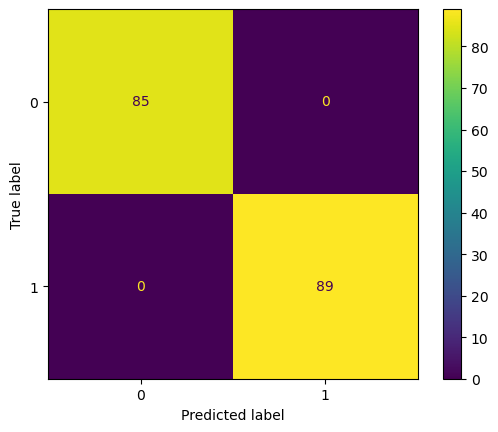

In [126]:
ebm_ye = ebm_clf.predict(X)

ebm_cm = confusion_matrix(y, ebm_ye)
ebm_metrics = perf_analysis.compute_metrics(ebm_cm)
display(ebm_metrics)

ConfusionMatrixDisplay.from_predictions(y, ebm_ye)

ebm_y2d = ebm_clf.predict_proba(X)[:, 1]

In [127]:
filename = "DARWIN_EBM_no_interactions.pkl"
with open(f"{models_dir}/{filename}", 'wb') as file:
    pickle.dump(ebm_clf, file)

In [128]:
visual = Visualization()

## Metrics

In [129]:
lr_metrics = lr_metrics.rename(columns={"Values": "LR"})
lr_metrics["LR"] = [round(x, 2) for x in lr_metrics["LR"]]
rf_metrics = rf_metrics.rename(columns={"Values": "RF"})
rf_metrics["RF"] = [round(x, 2) for x in rf_metrics["RF"]]
svm_metrics = svm_metrics.rename(columns={"Values": "SVM"})
svm_metrics["SVM"] = [round(x, 2) for x in svm_metrics["SVM"]]
ebm_metrics = ebm_metrics.rename(columns={"Values": "EBM"})
ebm_metrics["EBM"] = [round(x, 2) for x in ebm_metrics["EBM"]]

overall_metrics = pd.concat([lr_metrics, rf_metrics, svm_metrics, ebm_metrics], axis=1)
display(overall_metrics)

Metrics,LR,RF,SVM,EBM
accuracy,1.0,1.0,0.96,1.0
false-positive rate,0.0,0.0,0.02,0.0
false-negative rate,0.0,0.0,0.06,0.0
precision,1.0,1.0,0.98,1.0
recall,1.0,1.0,0.94,1.0
f-score,1.0,1.0,0.96,1.0
